### Libraries

In [ ]:
!pip install pydub

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#path='drive/MyDrive/Progetto DIGITAL/01_Classification - 1D/audio/Wav/'
path='drive/MyDrive/Progetto DIGITAL/01_Classification - 1D/rec/'

Mounted at /content/drive


In [ ]:
#import sounddevice as sd
from scipy.io.wavfile import write
#import speech_recognition as sr
from google.colab import files
import os
import time
import joblib
import numpy as np
import librosa
import librosa.display
from pydub import AudioSegment
from scipy.io import wavfile as wav # per file audio
import IPython.display as ipd
import matplotlib.pyplot as plt

#https://gist.github.com/arjunsharma97/0ecac61da2937ec52baf61af1aa1b759

# Classification instruments
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier 
from sklearn.utils import shuffle

#keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, Activation, Flatten
#from keras.optimizers import RMSprop
from keras.layers.noise import GaussianNoise
#from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import PReLU
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelEncoder
#from keras.utils import to_categorical
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization,Conv1D
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.layers import Dense,Dropout,Softmax,Flatten
from tensorflow.keras.layers import ZeroPadding2D,Convolution2D,MaxPooling2D,MaxPooling1D

In [ ]:
keras.__version__

'2.7.0'

## Data loader and preprocess

In [ ]:
def identity(input):
    return input

# Data loader
def load_data(feature_extractor=identity, augmentation=False, normalize=False):

    features = []
    labels_A = []
    labels_B = []
    labels_G = []
    labels_Bot = []

    for f in sorted(os.listdir("/content/"+ path)):
        if f.endswith('.wav'):
            # Load file and compute the requested features
            _, signal = wav.read("/content/"+ path + f)

            if len(signal.shape)>1 :
              signal = signal[:,0] # Monocanale

            # cur_features = feature_extractor(signal)
            features.append(signal)

            # Classes
            label = f.split('_')[0]

            if label == 'Anna':
               labels_A.append(1)
               labels_B.append(0)
               labels_G.append(0)
            elif label == 'Beatrice':
               labels_A.append(0)
               labels_B.append(1)
               labels_G.append(0)
            elif label == 'Guglielmo':
               labels_A.append(0)
               labels_B.append(0)
               labels_G.append(1)
            else:
               labels_A.append(0)
               labels_B.append(0)
               labels_G.append(0)

            num = f.split('_')[1]

            if num == "X":
               labels_Bot.append(0)
            else:
               labels_Bot.append(1)

    # X: features, y: labels
    X_train_temp, X_test_temp, y_train_A_temp, y_test_A = train_test_split(features, labels_A, test_size=0.1, random_state=1)
    X_train_temp, X_test_temp, y_train_B_temp, y_test_B = train_test_split(features, labels_B, test_size=0.1, random_state=1)
    X_train_temp, X_test_temp, y_train_G_temp, y_test_G = train_test_split(features, labels_G, test_size=0.1, random_state=1)
    X_train_temp, X_test_temp, y_train_Bot_temp, y_test_Bot = train_test_split(features, labels_Bot, test_size=0.1, random_state=1)

    X_train = []
    X_test = []
    y_train_A = []
    y_train_B = []
    y_train_G = []
    y_train_Bot = []

    for i in range(len(X_train_temp)):
        signal = X_train_temp[i]
        label_A = y_train_A_temp[i]
        label_B = y_train_B_temp[i]
        label_G = y_train_G_temp[i]
        label_Bot = y_train_Bot_temp[i]

        cur_features = feature_extractor(signal)
        X_train.append(cur_features)
        y_train_A.append(label_A)
        y_train_B.append(label_B)
        y_train_G.append(label_G)
        y_train_Bot.append(label_Bot)

        if augmentation == True:
          # Aumento il numero di segnali applicando delle trasformazioni
          # Noise
          signal_noise = add_noise(signal)
          cur_features = feature_extractor(signal_noise)
          X_train.append(cur_features)
          # Classe
          y_train_A.append(label_A)
          y_train_B.append(label_B)
          y_train_G.append(label_G)
          y_train_Bot.append(label_Bot)

          # Speed
          signal_speed = change_speed(signal)
          cur_features = feature_extractor(signal_noise)
          X_train.append(cur_features)
          # Classe
          y_train_A.append(label_A)
          y_train_B.append(label_B)
          y_train_G.append(label_G)
          y_train_Bot.append(label_Bot)

          # Pitch
          signal_pitch = change_pitch(signal)
          cur_features = feature_extractor(signal_pitch)
          X_train.append(cur_features)
          # Classe
          y_train_A.append(label_A)
          y_train_B.append(label_B)
          y_train_G.append(label_G)
          y_train_Bot.append(label_Bot)

    for i in range(len(X_test_temp)):
            signal = X_test_temp[i]

            cur_features = feature_extractor(signal)
            X_test.append(cur_features)       

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    return np.array(X_train), np.array(X_test), np.array(y_train_A), np.array(y_train_B), np.array(y_train_G), np.array(y_train_Bot), np.array(y_test_A), np.array(y_test_B), np.array(y_test_G), np.array(y_test_Bot), X_train_mean, X_train_std

## Feature extraction


In [ ]:
# Funzioni di guglielmo
def add_noise(data, factor=200):
  noise = np.random.randn(len(data))
  noised_data = (data + noise*factor)
  return noised_data

def change_pitch(data, sampling_rate=24000, pitch_factor=1):
    audio_pitched = librosa.effects.pitch_shift(data.astype('float32'),sampling_rate,pitch_factor)
    return audio_pitched

def change_speed(data, speed_factor=1.3):
    audio_speed = librosa.effects.time_stretch(data.astype('float32'), speed_factor)
    return audio_speed

# Features functions 

def sdev(input):
    return np.std(input, keepdims=True)

def aavg(input):
    return np.mean(np.abs(input), keepdims=True)

def energy(input):
    return np.sum((input*1.0)**2, keepdims=True)

def zcr(input):
    return np.array([np.nonzero(np.diff(input>0))[0].size])

def combo(input):
    return np.concatenate((aavg(input),sdev(input),energy(input), zcr(input)))

In [ ]:
# MFCC Features function 
def mfcc(input, rate=48000, min_len=300, sampling=1): 
    signal = input[::sampling]
    mfcc = librosa.feature.mfcc(signal*1.0, sr=int(rate/sampling))
    # Add additional necessary zeroes to reach the required length
    pad_width = min_len - mfcc.shape[1]
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    mfcc = mfcc.flatten()
    return np.array(mfcc)

def combo_mfcc(input):
  return np.concatenate((aavg(input),sdev(input),energy(input), zcr(input), mfcc(input)))

## Model

In [ ]:
def build_model():

  dropout_rate=0.3

  input_layer=Input(shape=(np.shape(X_train)[1]))

  x= Dense(256, activation='relu')(input_layer)
  x= Dropout(dropout_rate)(x)
  x= Dense(256, activation='relu')(x)
  x= Dropout(dropout_rate)(x)
  x= Dense(128, activation='relu')(x)
  x= Dropout(dropout_rate)(x)

  ### PEOPLE

  output_Anna= Dense(2, activation='softmax', name='Anna')(x)
  output_Beatrice= Dense(2, activation='softmax', name='Beatrice')(x)
  output_Gugliemo = Dense(2, activation='softmax', name='Gugliemo')(x)

  ### VOCAL ASSISTANT 

  output_Bot = Dense(2, activation='softmax', name='B-Bot')(x)

  model = Model(input_layer, [output_Anna,output_Beatrice,output_Gugliemo,output_Bot])

  losses = {"Anna": "binary_crossentropy",
            "Beatrice": "binary_crossentropy",
            "Gugliemo": "binary_crossentropy",
            "B-Bot": "binary_crossentropy"}

  model.compile(loss=losses,optimizer='Adam', metrics=['accuracy'])

  return model

In [ ]:
X_train, X_test, y_train_A, y_train_B, y_train_G, y_train_Bot, y_test_A, y_test_B, y_test_G, y_test_Bot, mean, sd = load_data(feature_extractor=combo_mfcc, augmentation= True, normalize=True)

In [ ]:
X_train.shape

(2548, 6004)

In [ ]:
print("Training samples: "+str(len(X_train)))
print("Validation samples: "+str(len(X_test)))

Training samples: 2548
Validation samples: 71


In [ ]:
model = build_model()

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6004)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          1537280     ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 256)          0           ['dense[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 256)          65792       ['dropout[0][0]']                
                                                                                              

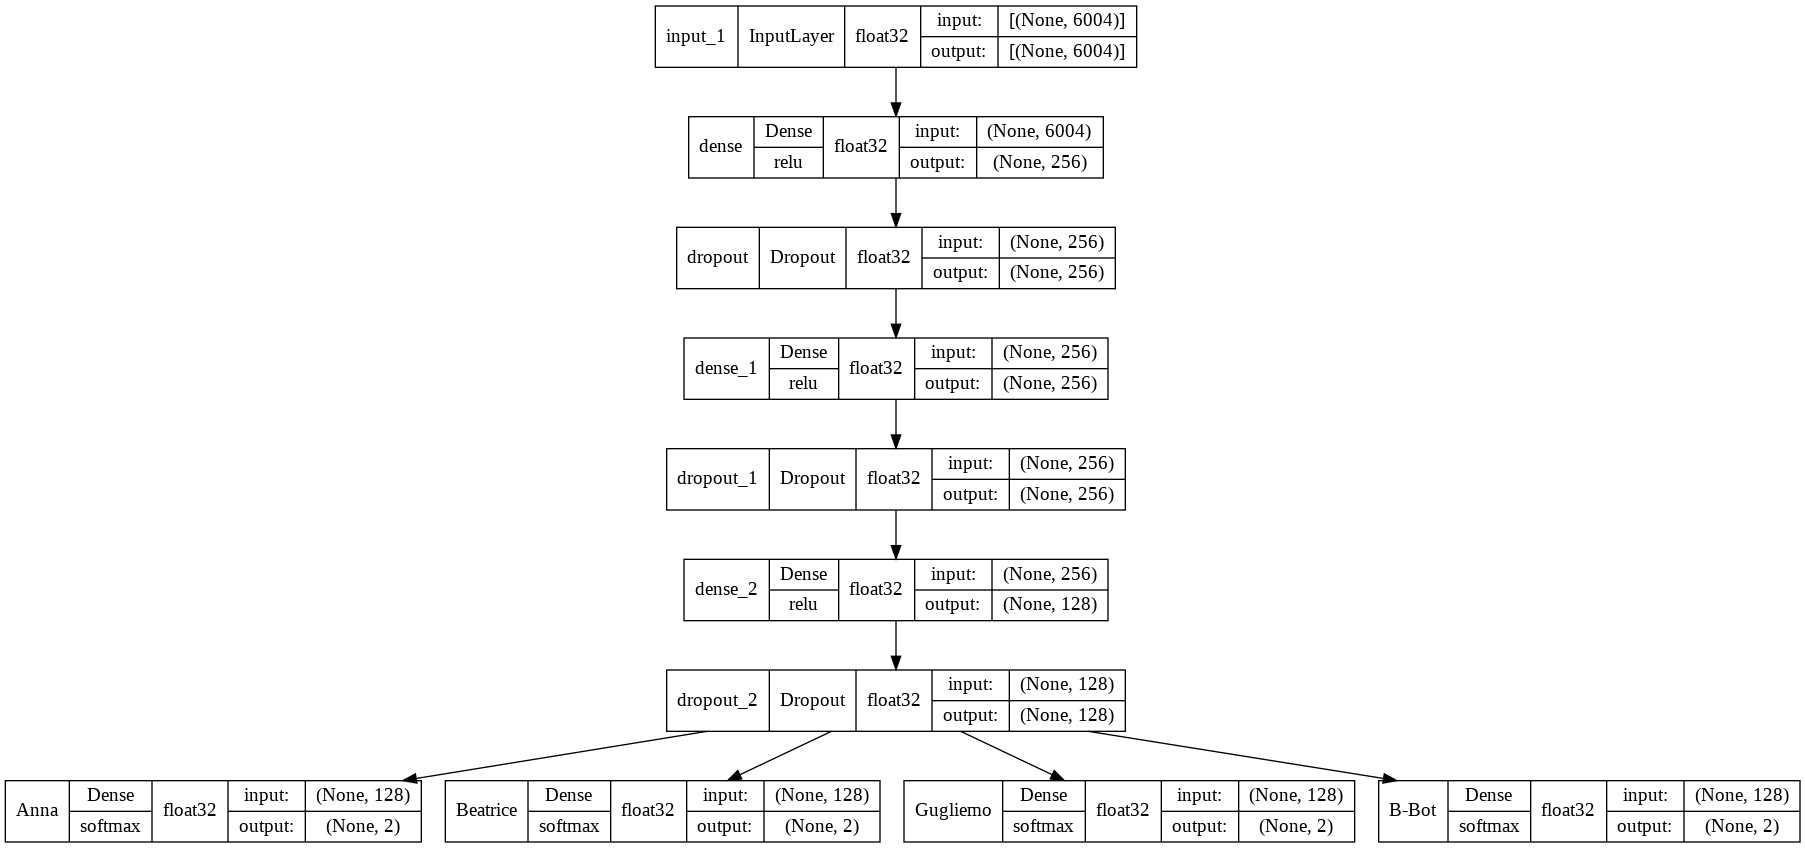

In [ ]:
keras.utils.plot_model(model, to_file='model.png',show_shapes=True, show_dtype=True, show_layer_activations=True)

In [ ]:
le = LabelEncoder()
y_train_A = tf.keras.utils.to_categorical(le.fit_transform(y_train_A))
y_train_B = tf.keras.utils.to_categorical(le.fit_transform(y_train_B))
y_train_G = tf.keras.utils.to_categorical(le.fit_transform(y_train_G))
y_train_Bot = tf.keras.utils.to_categorical(le.fit_transform(y_train_Bot))
y_test_A = tf.keras.utils.to_categorical(le.fit_transform(y_test_A))
y_test_B = tf.keras.utils.to_categorical(le.fit_transform(y_test_B))
y_test_G = tf.keras.utils.to_categorical(le.fit_transform(y_test_G))
y_test_Bot = tf.keras.utils.to_categorical(le.fit_transform(y_test_Bot))

In [ ]:
history = model.fit(X_train,[y_train_A, y_train_B, y_train_G, y_train_Bot], 
                    validation_data=(X_test, [y_test_A, y_test_B, y_test_G, y_test_Bot]), 
                    batch_size=10, epochs=20, verbose=1)

Epoch 1/20
255/255 [==============================] - 7s 13ms/step - loss: 0.9127 - Anna_loss: 0.2079 - Beatrice_loss: 0.1696 - Gugliemo_loss: 0.1301 - B-Bot_loss: 0.4051 - Anna_accuracy: 0.9403 - Beatrice_accuracy: 0.9517 - Gugliemo_accuracy: 0.9678 - B-Bot_accuracy: 0.8689 - val_loss: 0.9211 - val_Anna_loss: 0.1935 - val_Beatrice_loss: 0.2673 - val_Gugliemo_loss: 0.0015 - val_B-Bot_loss: 0.4586 - val_Anna_accuracy: 0.9437 - val_Beatrice_accuracy: 0.9577 - val_Gugliemo_accuracy: 1.0000 - val_B-Bot_accuracy: 0.8310
Epoch 2/20
255/255 [==============================] - 3s 11ms/step - loss: 0.2590 - Anna_loss: 0.0430 - Beatrice_loss: 0.0363 - Gugliemo_loss: 0.0201 - B-Bot_loss: 0.1597 - Anna_accuracy: 0.9902 - Beatrice_accuracy: 0.9925 - Gugliemo_accuracy: 0.9961 - B-Bot_accuracy: 0.9611 - val_loss: 0.5908 - val_Anna_loss: 0.0432 - val_Beatrice_loss: 0.0971 - val_Gugliemo_loss: 0.0150 - val_B-Bot_loss: 0.4354 - val_Anna_accuracy: 0.9718 - val_Beatrice_accuracy: 0.9577 - val_Gugliemo_accu

In [ ]:
y_test_list = [y_test_A, y_test_B, y_test_G, y_test_Bot]
names = ['Anna', 'Beatrice', 'Guglielmo', 'B-Bot']
pos = 0

y_pred = model.predict(X_test)
for y in y_test_list:
  print("\n -", names[pos])
  y_pred_ = np.argmax(y_pred[pos], axis = 1)
  y_test = np.argmax(y_test_list[pos], axis = 1)
  print(classification_report(y_test, y_pred_, digits = 2))
  pos+=1


 - Anna
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        48
           1       0.92      0.96      0.94        23

    accuracy                           0.96        71
   macro avg       0.95      0.96      0.95        71
weighted avg       0.96      0.96      0.96        71


 - Beatrice
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        47
           1       1.00      0.92      0.96        24

    accuracy                           0.97        71
   macro avg       0.98      0.96      0.97        71
weighted avg       0.97      0.97      0.97        71


 - Guglielmo
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        21

    accuracy                           1.00        71
   macro avg       1.00      1.00      1.00        71
weighted avg       1.00      1.00     

In [ ]:
# Save model
model.save('NN_BinaryClassifierCombo_1D.h5')
#files.download('NN_BinaryClassifierCombo_1D.h5')
!cp NN_BinaryClassifierCombo_1D.h5 '/content/drive/MyDrive/Progetto DIGITAL/01_Classification - 1D/Modelli/' 

In [ ]:
np.savez_compressed('metrics_audio_classification', Mean=mean, Sd = sd )

!cp metrics_audio_classification.npz '/content/drive/MyDrive/Progetto DIGITAL/01_Classification - 1D/'

# Altri modelli testati

In [ ]:
def identity(input):
    return input

# Data loader
def load_data(feature_extractor=identity, normalize=False):

    labels = []
    features = []
    labels_Bot = []

    for f in sorted(os.listdir("/content/"+ path)):
        if f.endswith('.wav'):
            # Load file and compute the requested features
            _, signal = wav.read("/content/"+ path + f)

            if len(signal.shape)>1 :
              signal = signal[:,0] # Monocanale

            # cur_features = feature_extractor(signal)
            features.append(signal)

            # Classes
            label = f.split('_')[0]
            labels.append(label)

            num = f.split('_')[1]

            if num == "X":
               labels_Bot.append(0)
            else:
               labels_Bot.append(1)

    # X: features, y: labels
    X_train_temp, X_test_temp, y_train_temp, y_test = train_test_split(features, labels, test_size=0.1, random_state=1)
    X_train_temp, X_test_temp, y_train_Bot_temp, y_test_Bot = train_test_split(features, labels_Bot, test_size=0.1, random_state=1)

    X_train = []
    X_test = []
    y_train = []
    y_train_Bot = []

    for i in range(len(X_train_temp)):
        signal = X_train_temp[i]
        label = y_train_temp[i]
        label_Bot = y_train_Bot_temp[i]

        cur_features = feature_extractor(signal)
        X_train.append(cur_features)
        y_train.append(label)
        y_train_Bot.append(label_Bot)

        # Aumento il numero di segnali applicando delle trasformazioni
        # Noise
        signal_noise = add_noise(signal)
        cur_features = feature_extractor(signal_noise)
        X_train.append(cur_features)
        # Classe
        y_train.append(label)
        y_train_Bot.append(label_Bot)

        # Speed
        signal_speed = change_speed(signal)
        cur_features = feature_extractor(signal_noise)
        X_train.append(cur_features)
        # Classe
        y_train.append(label)
        y_train_Bot.append(label_Bot)

        # Pitch
        signal_pitch = change_pitch(signal)
        cur_features = feature_extractor(signal_pitch)
        X_train.append(cur_features)
        # Classe
        y_train.append(label)
        y_train_Bot.append(label_Bot)

    for i in range(len(X_test_temp)):
            signal = X_test_temp[i]

            cur_features = feature_extractor(signal)
            X_test.append(cur_features)       

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test), np.array(y_train_Bot), np.array(y_test_Bot), X_train_mean, X_train_std

In [ ]:
X_train, X_test, y_train, y_test, y_train_Bot, y_test_Bot, mean, sd = load_data(feature_extractor=combo_mfcc, normalize=True) 

In [ ]:
print("Training samples: "+str(len(X_train)))
print("Validation samples: "+str(len(X_test)))

In [ ]:
# For NNet models
n_features = np.shape(X_train)[1]
classes = len(np.unique(y_train))

## Random Forest

In [ ]:
# Hyperparameters to test with cross validation
param_grid_rf = {'n_estimators': [1, 4, 8, 12, 16, 20],
                 'criterion': ['entropy', 'gini'], }

clf_rf = GridSearchCV(RandomForestClassifier(),param_grid_rf)

clf_rf = clf_rf.fit(X_train, y_train)

In [ ]:
# Results for best hyperparameters
print("Best parameters:")
print(" n_estimators: "+str(clf_rf.best_estimator_.n_estimators))
print(" criterion: "+str(clf_rf.best_estimator_.criterion))

In [ ]:
clf_rf_pred = clf_rf.predict(X_test) 

In [ ]:
clf_rf_pred

In [ ]:
print(classification_report(y_test, clf_rf_pred))

In [ ]:
cm = confusion_matrix(y_test, clf_rf_pred)   
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)

In [ ]:
print(accuracy_score(y_test, clf_rf_pred))

## Support Vector Machine

In [ ]:
# Hyperparameters to try
param_grid_svc = {'C': [10, 50, 100, 150, 1000],
                  'gamma': [0.005, 0.001, 0.01, 0.5],
                  'kernel': ['linear', 'rbf', 'poly']}

clf_svc = GridSearchCV(SVC(class_weight='balanced',probability=True), param_grid_svc, cv=3)

clf_svc = clf_svc.fit(X_train, y_train)

In [ ]:
# Optimization results
print("Best parameters:")
print(" C: "+str(clf_svc.best_estimator_.C))
print(" gamma: "+str(clf_svc.best_estimator_.gamma))
print(" kernel: "+str(clf_svc.best_estimator_.kernel))

In [ ]:
clf_svc_pred = clf_svc.predict(X_test)

In [ ]:
print(classification_report(y_test, clf_svc_pred))

In [ ]:
cm = confusion_matrix(y_test, clf_svc_pred)
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)

In [ ]:
print(accuracy_score(y_test, clf_svc_pred))

## Neural Network
Speaker and vocal assistant recognition combined

In [ ]:
# one hot encoding del target
le = LabelEncoder()
y_train_transformed = tf.keras.utils.to_categorical(le.fit_transform(y_train)) 
y_test_transformed = tf.keras.utils.to_categorical(le.fit_transform(y_test))
# B-Bot
y_train_Bot = tf.keras.utils.to_categorical(le.fit_transform(y_train_Bot))
y_test_Bot = tf.keras.utils.to_categorical(le.fit_transform(y_test_Bot))

In [ ]:
def build_model():

  dropout_rate=0.3

  input_layer=Input(shape=(np.shape(X_train)[1]))

  x= Dense(256, activation='relu')(input_layer)
  x= Dropout(dropout_rate)(x)
  x= Dense(256, activation='relu')(x)
  x= Dropout(dropout_rate)(x)
  x= Dense(128, activation='relu')(x)
  x= Dropout(dropout_rate)(x)

  ### PEOPLE NETWORK

  output= Dense(classes, activation='softmax', name='Speaker')(x)
  
  ### VOCAL ASSISTANT NETWORK

  output_Bot = Dense(2, activation='softmax', name='B-Bot')(x)

  model = Model(input_layer, [output,output_Bot])

  losses = {"Speaker": "categorical_crossentropy",
            "B-Bot": "binary_crossentropy"}

  model.compile(loss=losses,optimizer='Adam', metrics=['accuracy'])

  return model

In [ ]:
model = build_model()

In [ ]:
model.summary()

In [ ]:
keras.utils.plot_model(model, to_file='model.png')

In [ ]:
history = model.fit(X_train,[y_train_transformed, y_train_Bot], 
                    validation_data=(X_test, [y_test_transformed, y_test_Bot]), 
                    batch_size=10, epochs=20, verbose=1)

In [ ]:
y_test_list = [y_test_transformed, y_test_Bot]
names = ['Speaker', 'B-Bot']
pos = 0

y_pred = model.predict(X_test)
for y in y_test_list:
  print("\n -", names[pos])
  y_pred_ = np.argmax(y_pred[pos], axis = 1)
  y_test = np.argmax(y_test_list[pos], axis = 1)
  print(classification_report(y_test, y_pred_, digits = 2))
  pos+=1